TERNAUS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def decoder_block_ternausV2(inputs, skip_features, mid_channels, out_channels, batch_norm=True):
    """
    Decoder block as proposed for TernausNet16 with skip connections.
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'
    )

    bn_kwargs = {
        'axis': -1,
        'momentum': 0.9,
        'epsilon': 1e-5
    }

    x = layers.UpSampling2D(size=(2, 2))(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(mid_channels, 3, **conv_kwargs)(x)
    if batch_norm:
        x = layers.BatchNormalization(**bn_kwargs)(x)
    x = layers.Conv2D(out_channels, 3, **conv_kwargs)(x)
    if batch_norm:
        x = layers.BatchNormalization(**bn_kwargs)(x)

    return x

def ternausNet_with_vgg11(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Load pre-trained VGG11 model as encoder
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder (using VGG11 convolutional layers as feature extractors)
    c1 = vgg.get_layer("block1_conv2").output  # (None, 256, 256, 64)
    c2 = vgg.get_layer("block2_conv2").output  # (None, 128, 128, 128)
    c3 = vgg.get_layer("block3_conv3").output  # (None, 64, 64, 256)
    c4 = vgg.get_layer("block4_conv3").output  # (None, 32, 32, 512)
    c5 = vgg.get_layer("block5_conv3").output  # (None, 16, 16, 512)

    # Decoder
    d4 = decoder_block_ternausV2(c5, c4, 512, 256)
    d3 = decoder_block_ternausV2(d4, c3, 256, 128)
    d2 = decoder_block_ternausV2(d3, c2, 128, 64)
    d1 = decoder_block_ternausV2(d2, c1, 64, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d1)

    # Create the model
    model = models.Model(inputs=vgg.input, outputs=outputs)

    return model

# Create the TernausNet model with pre-trained VGG11 encoder
input_shape = (256, 256, 3)
model = ternausNet_with_vgg11(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'auc', 'binary_accuracy', 'recall'])

# Display model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 22,555,521 (86.04 MB)

 Trainable params: 22,552,641 (86.03 MB)

 Non-trainable params: 2,880 (11.25 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


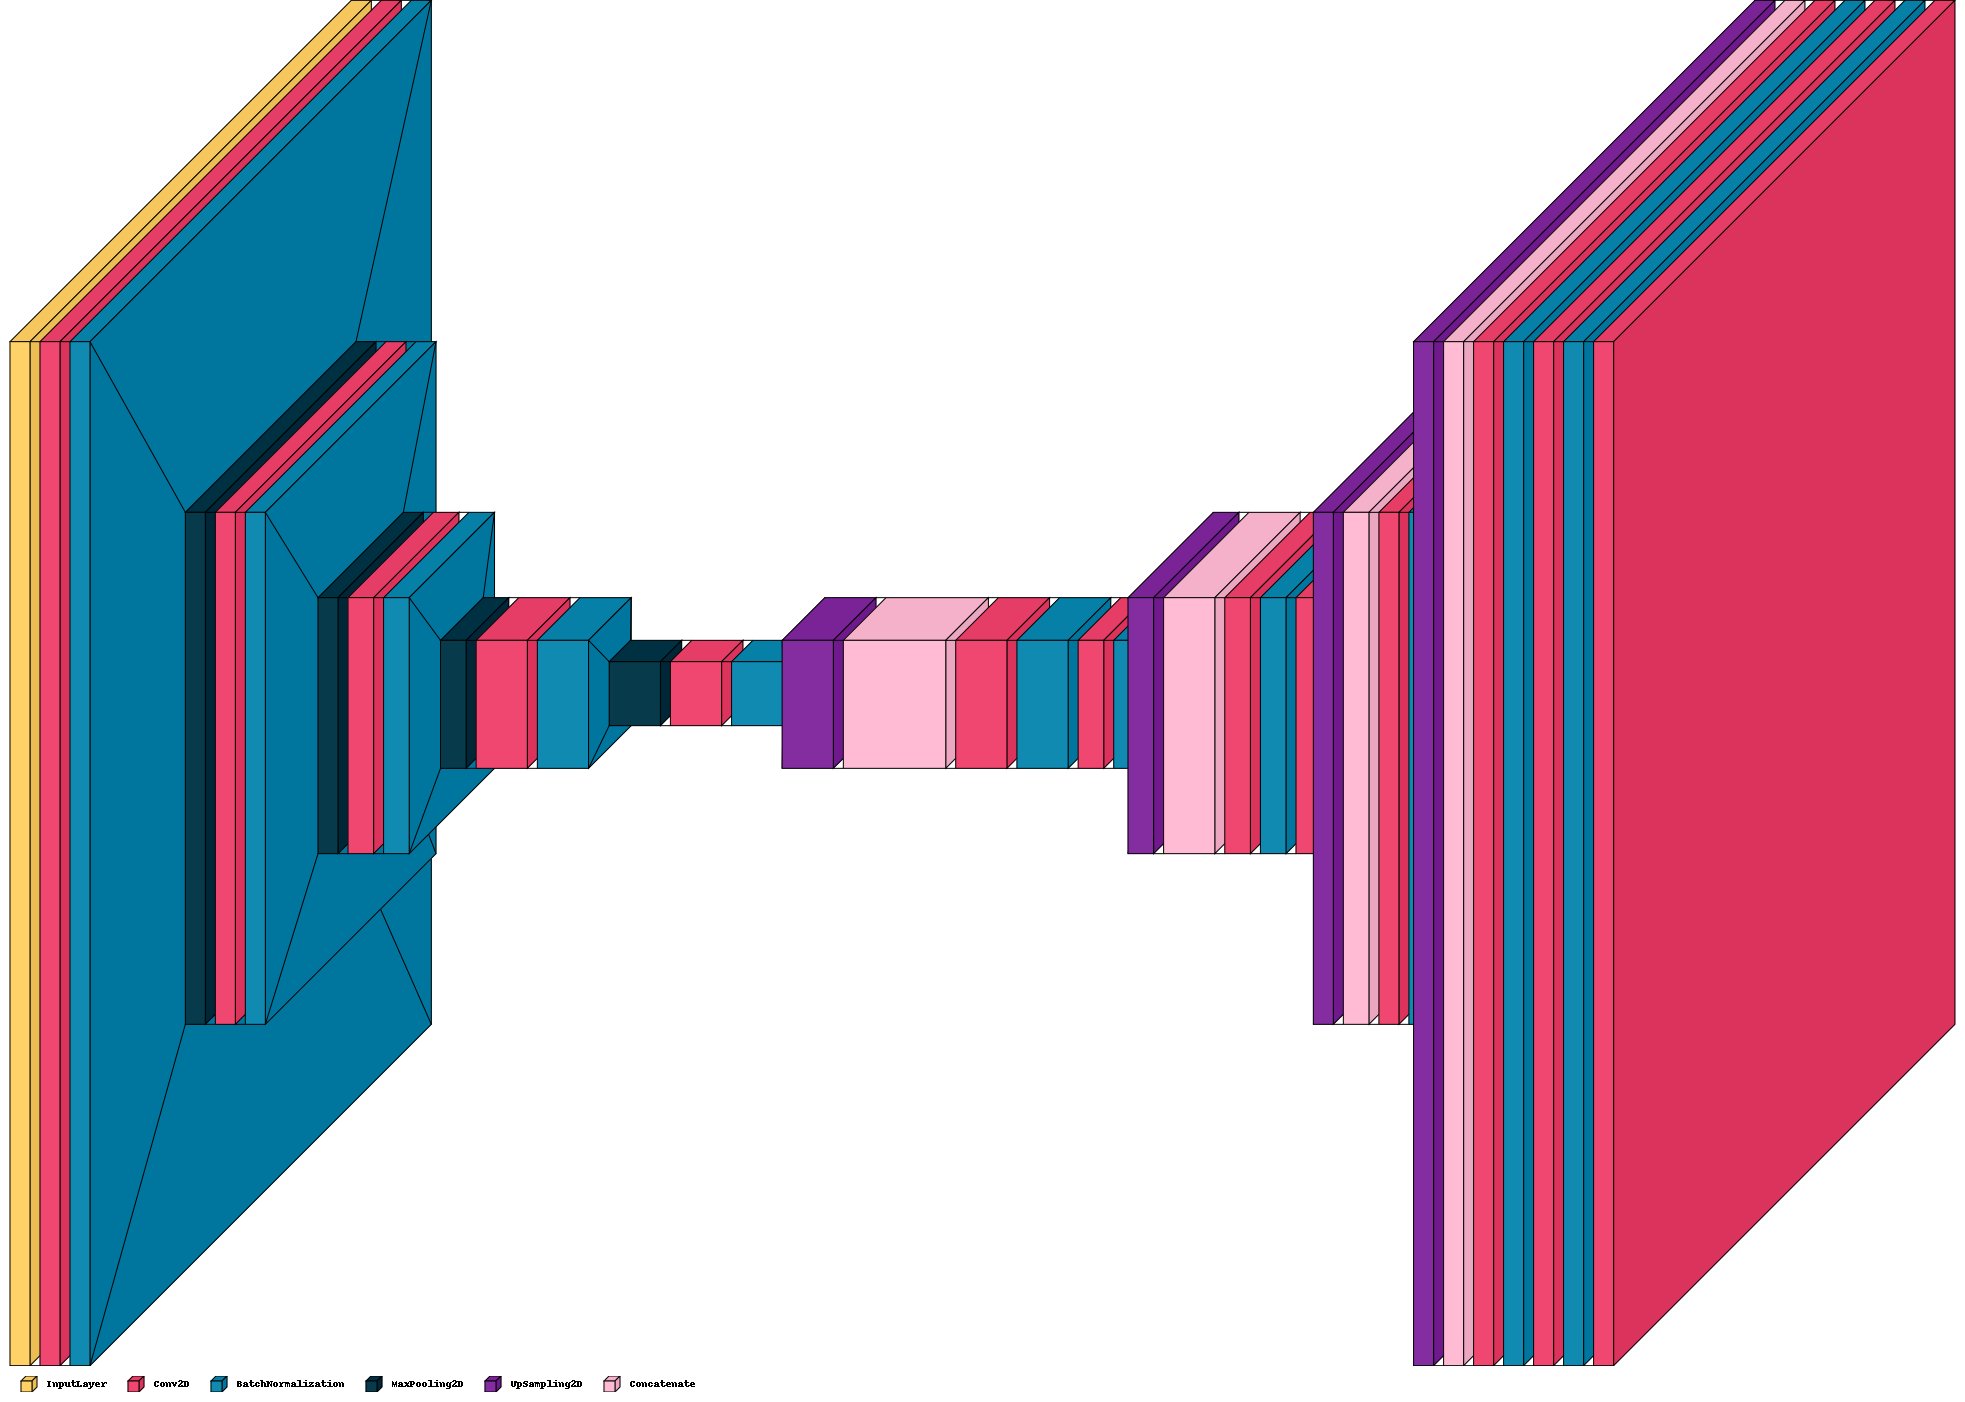

In [ ]:
#!pip3 install visualkeras
import visualkeras

visualkeras.layered_view(model, legend=True)

In [ ]:
model.save('/content/drive/My Drive/Segnet IDD Project/Version 5/ternaus.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')